## Step 1. Importing Libraries

In [ ]:
import os
import datetime as dt
import glob
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import noisereduce as nr
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import numpy as np
import matplotlib.pyplot as plt

# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from tensorflow.keras.models import Sequential, model_from_json

%matplotlib inline
%load_ext tensorboard
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Dataframe generation

In [ ]:
# File path
Jannatul = '.../Speaker-recognition/Dataset/Jannatul/*'
Mahabuba =  '.../Speaker-recognition/Dataset/Mahabuba/*'
Shezan = '.../Speaker-recognition/Dataset/Shezan/*'
Unknown = '.../Speaker-recognition/Dataset/Unknown/*'

In [ ]:
# Jannatul
df1=pd.DataFrame(columns=['filename','target','category'])
df1.set_index('filename')
df1['filename'] = pd.Series([file for file in glob.glob(Jannatul)])
df1['target'] = 0
df1['category'] = 'Jannatul'

# Mahabuba
df2=pd.DataFrame(columns=['filename','target','category'])
df2.set_index('filename')
df2['filename'] = pd.Series([file for file in glob.glob(Mahabuba)]) 
df2['target'] = 1
df2['category'] = 'Mahabuba'

# Shezan
df3=pd.DataFrame(columns=['filename','target','category'])
df3.set_index('filename')
df3['filename'] = pd.Series([file for file in glob.glob(Shezan)])
df3['target'] = 2
df3['category'] = 'Shezan'

# Unknown
df4=pd.DataFrame(columns=['filename','target','category'])
df4.set_index('filename')
df4['filename'] = pd.Series([file for file in glob.glob(Unknown)])
df4['target'] = 3
df4['category'] = 'Unknown'
 
# Concat
df = pd.concat([df1, df2, df3, df4], ignore_index = True, axis = 0)

,target,category
filename,,


,target,category
filename,,


,target,category
filename,,


,target,category
filename,,


## Step 2. Loading and Preprocessing

In [ ]:
df

,filename,target,category
0,/content/drive/MyDrive/Voice Recognition Proje...,0,Jannatul
1,/content/drive/MyDrive/Voice Recognition Proje...,0,Jannatul
2,/content/drive/MyDrive/Voice Recognition Proje...,0,Jannatul
3,/content/drive/MyDrive/Voice Recognition Proje...,0,Jannatul
4,/content/drive/MyDrive/Voice Recognition Proje...,0,Jannatul
...,...,...,...
698,/content/drive/MyDrive/Voice Recognition Proje...,3,Unknown
699,/content/drive/MyDrive/Voice Recognition Proje...,3,Unknown
700,/content/drive/MyDrive/Voice Recognition Proje...,3,Unknown
701,/content/drive/MyDrive/Voice Recognition Proje...,3,Unknown


In [ ]:
classes = df['category'].unique()
classes

array(['Jannatul', 'Mahabuba', 'Shezan', 'Unknown'], dtype=object)

In [ ]:
class_dict = {i:x for x,i in enumerate(classes)}
class_dict

{'Jannatul': 0, 'Mahabuba': 1, 'Shezan': 2, 'Unknown': 3}

## Step 3. Visualization

Taking one sample from each of the 4 classes for visualization

In [ ]:
sample_df = df.drop_duplicates(subset=['target'])
sample_df

,filename,target,category
0,/content/drive/MyDrive/Voice Recognition Proje...,0,Jannatul
201,/content/drive/MyDrive/Voice Recognition Proje...,1,Mahabuba
403,/content/drive/MyDrive/Voice Recognition Proje...,2,Shezan
553,/content/drive/MyDrive/Voice Recognition Proje...,3,Unknown


In [ ]:
signals = {}
mel_spectrograms = {}
mfccs = {}

for row in tqdm(sample_df.iterrows()): 
    print(row[1][0])
    signal , rate = librosa.load(row[1][0])
    signals[row[1][2]] = signal     
    mel_spec = librosa.feature.melspectrogram(y=signal , sr=rate ,  n_fft=2048, hop_length=512)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spectrograms[row[1][2]] = mel_spec    
    mfcc = librosa.feature.mfcc(signal , rate , n_mfcc=13, dct_type=3)
    mfccs[row[1][2]] = mfcc

0it [00:00, ?it/s]

/content/drive/MyDrive/Voice Recognition Project/Dataset/Jannatul/wav/6cd39cbb-cfbc-4f6e-8eb9-9f6d2e084211-byVC.wav


1it [00:01,  1.28s/it]

/content/drive/MyDrive/Voice Recognition Project/Dataset/Mahabuba/wav/test1.wav


2it [00:02,  1.23s/it]

/content/drive/MyDrive/Voice Recognition Project/Dataset/Shezan/wav/test 12.wav


3it [00:03,  1.30s/it]

/content/drive/MyDrive/Voice Recognition Project/Dataset/Unknown/wav/a0404.wav


4it [00:04,  1.17s/it]


In [ ]:
def plot_signal(signal):
    fig , axes = plt.subplots(nrows=2 , ncols=2 , sharex =False ,sharey=True,
                             figsize=(40,20))
    fig.suptitle('Time series',size=15)
    i=0
    for x in range(2):
        for y in range(2):
            axes[x,y].set_title(list(signal.keys())[i])
            axes[x,y].plot(list(signal.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

In [ ]:
def dis_feature(mfccs, cmap=None):
    fig ,axes= plt.subplots(nrows=2 , ncols=2 , sharex=False, sharey=True , figsize=(40,20))
    fig.suptitle('mel')
    i=0
    for x in range(2):
        for y in range(2):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i], cmap=cmap,interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i+=1

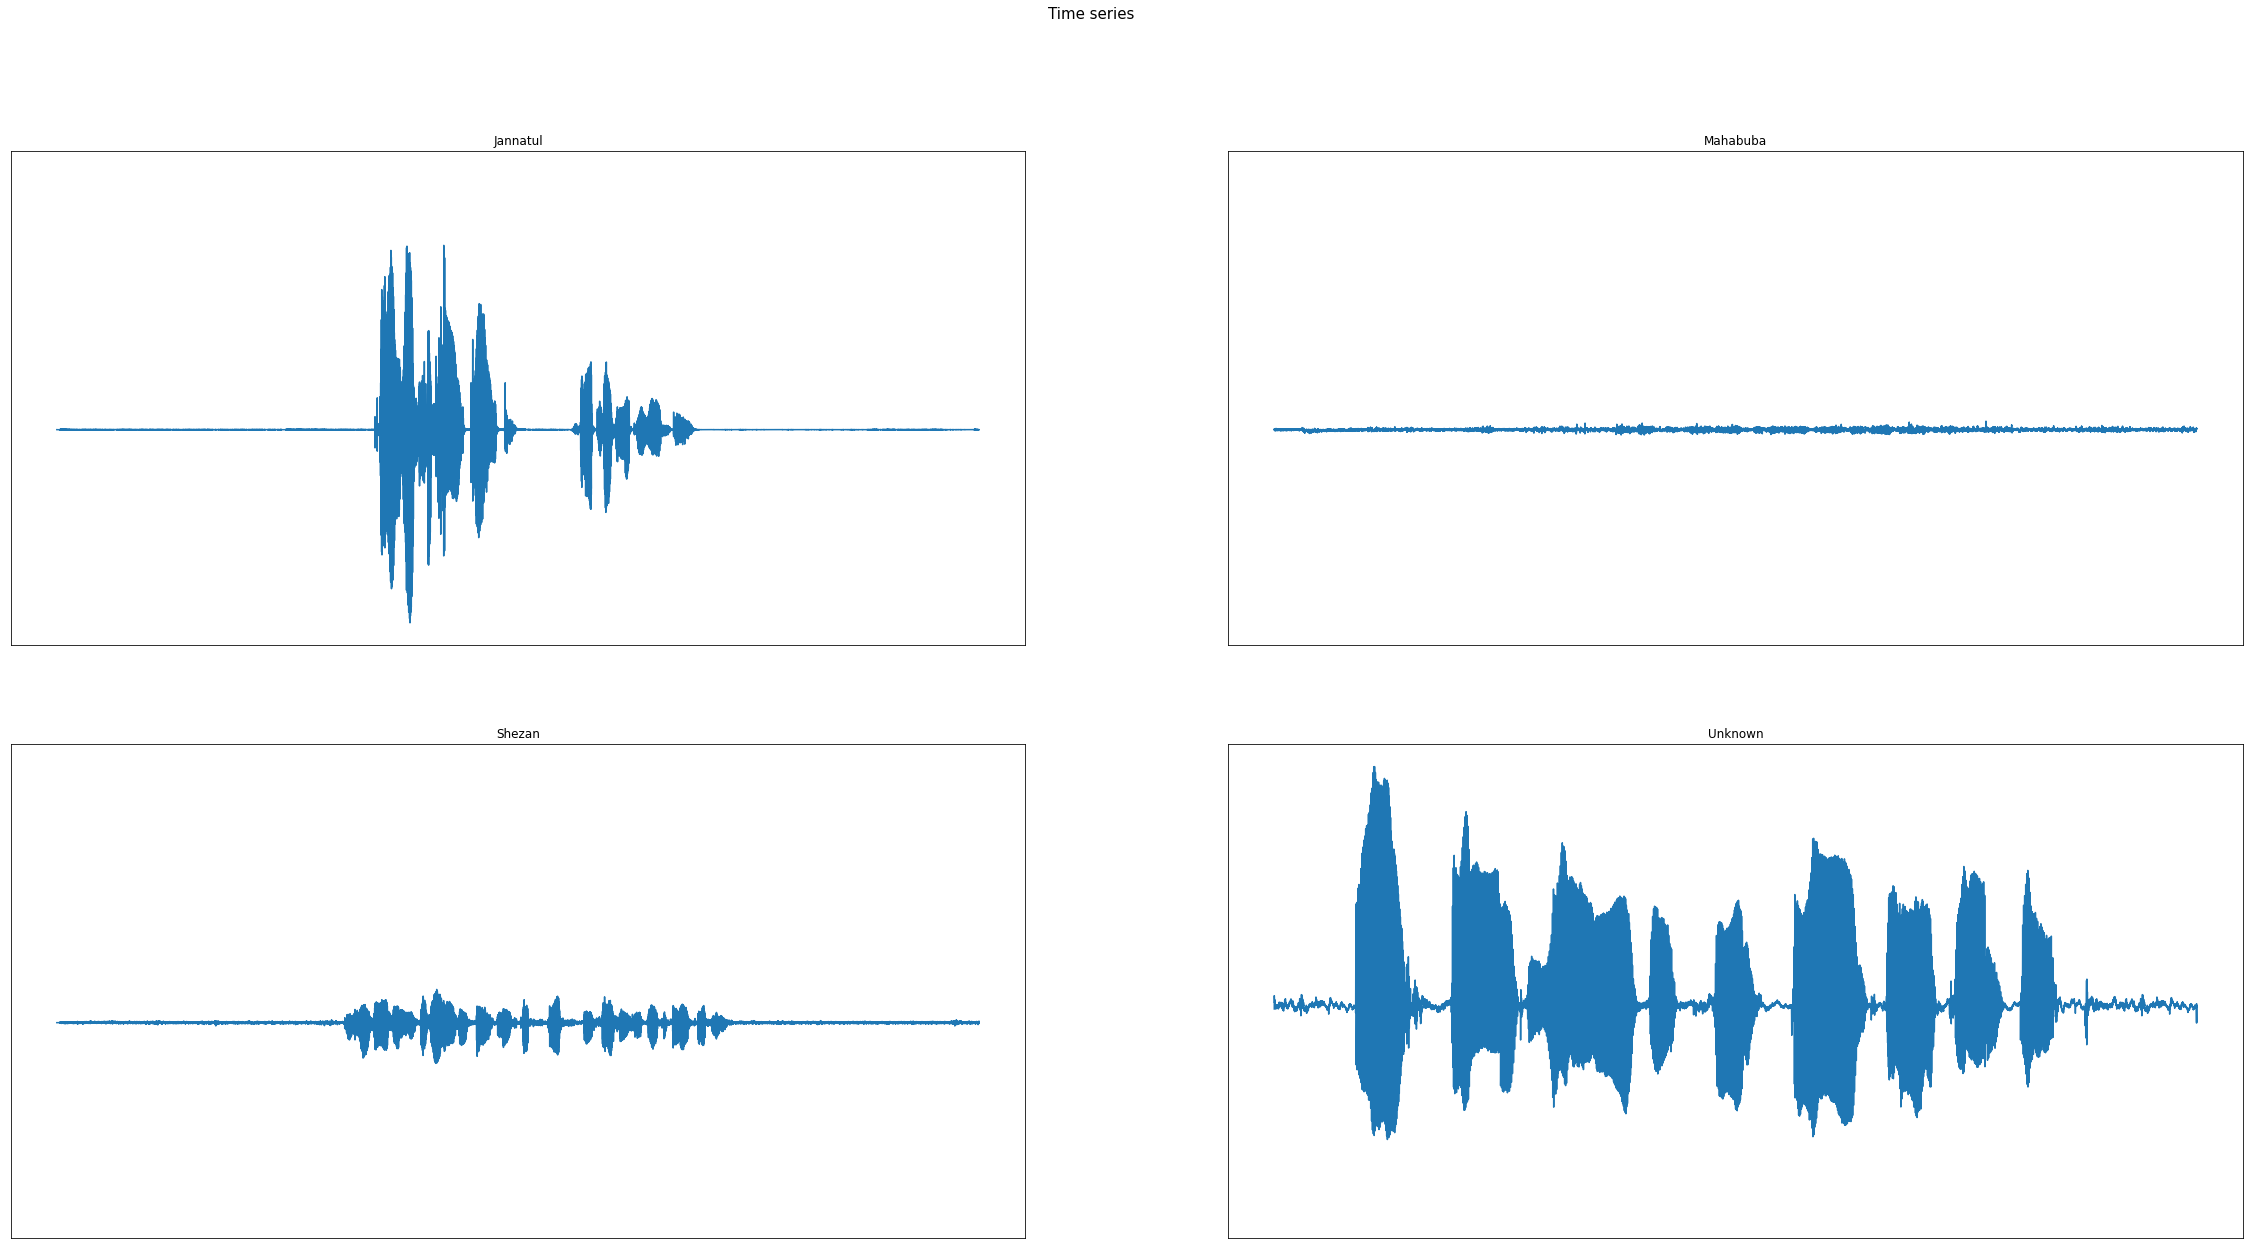

In [ ]:
plot_signal(signals)

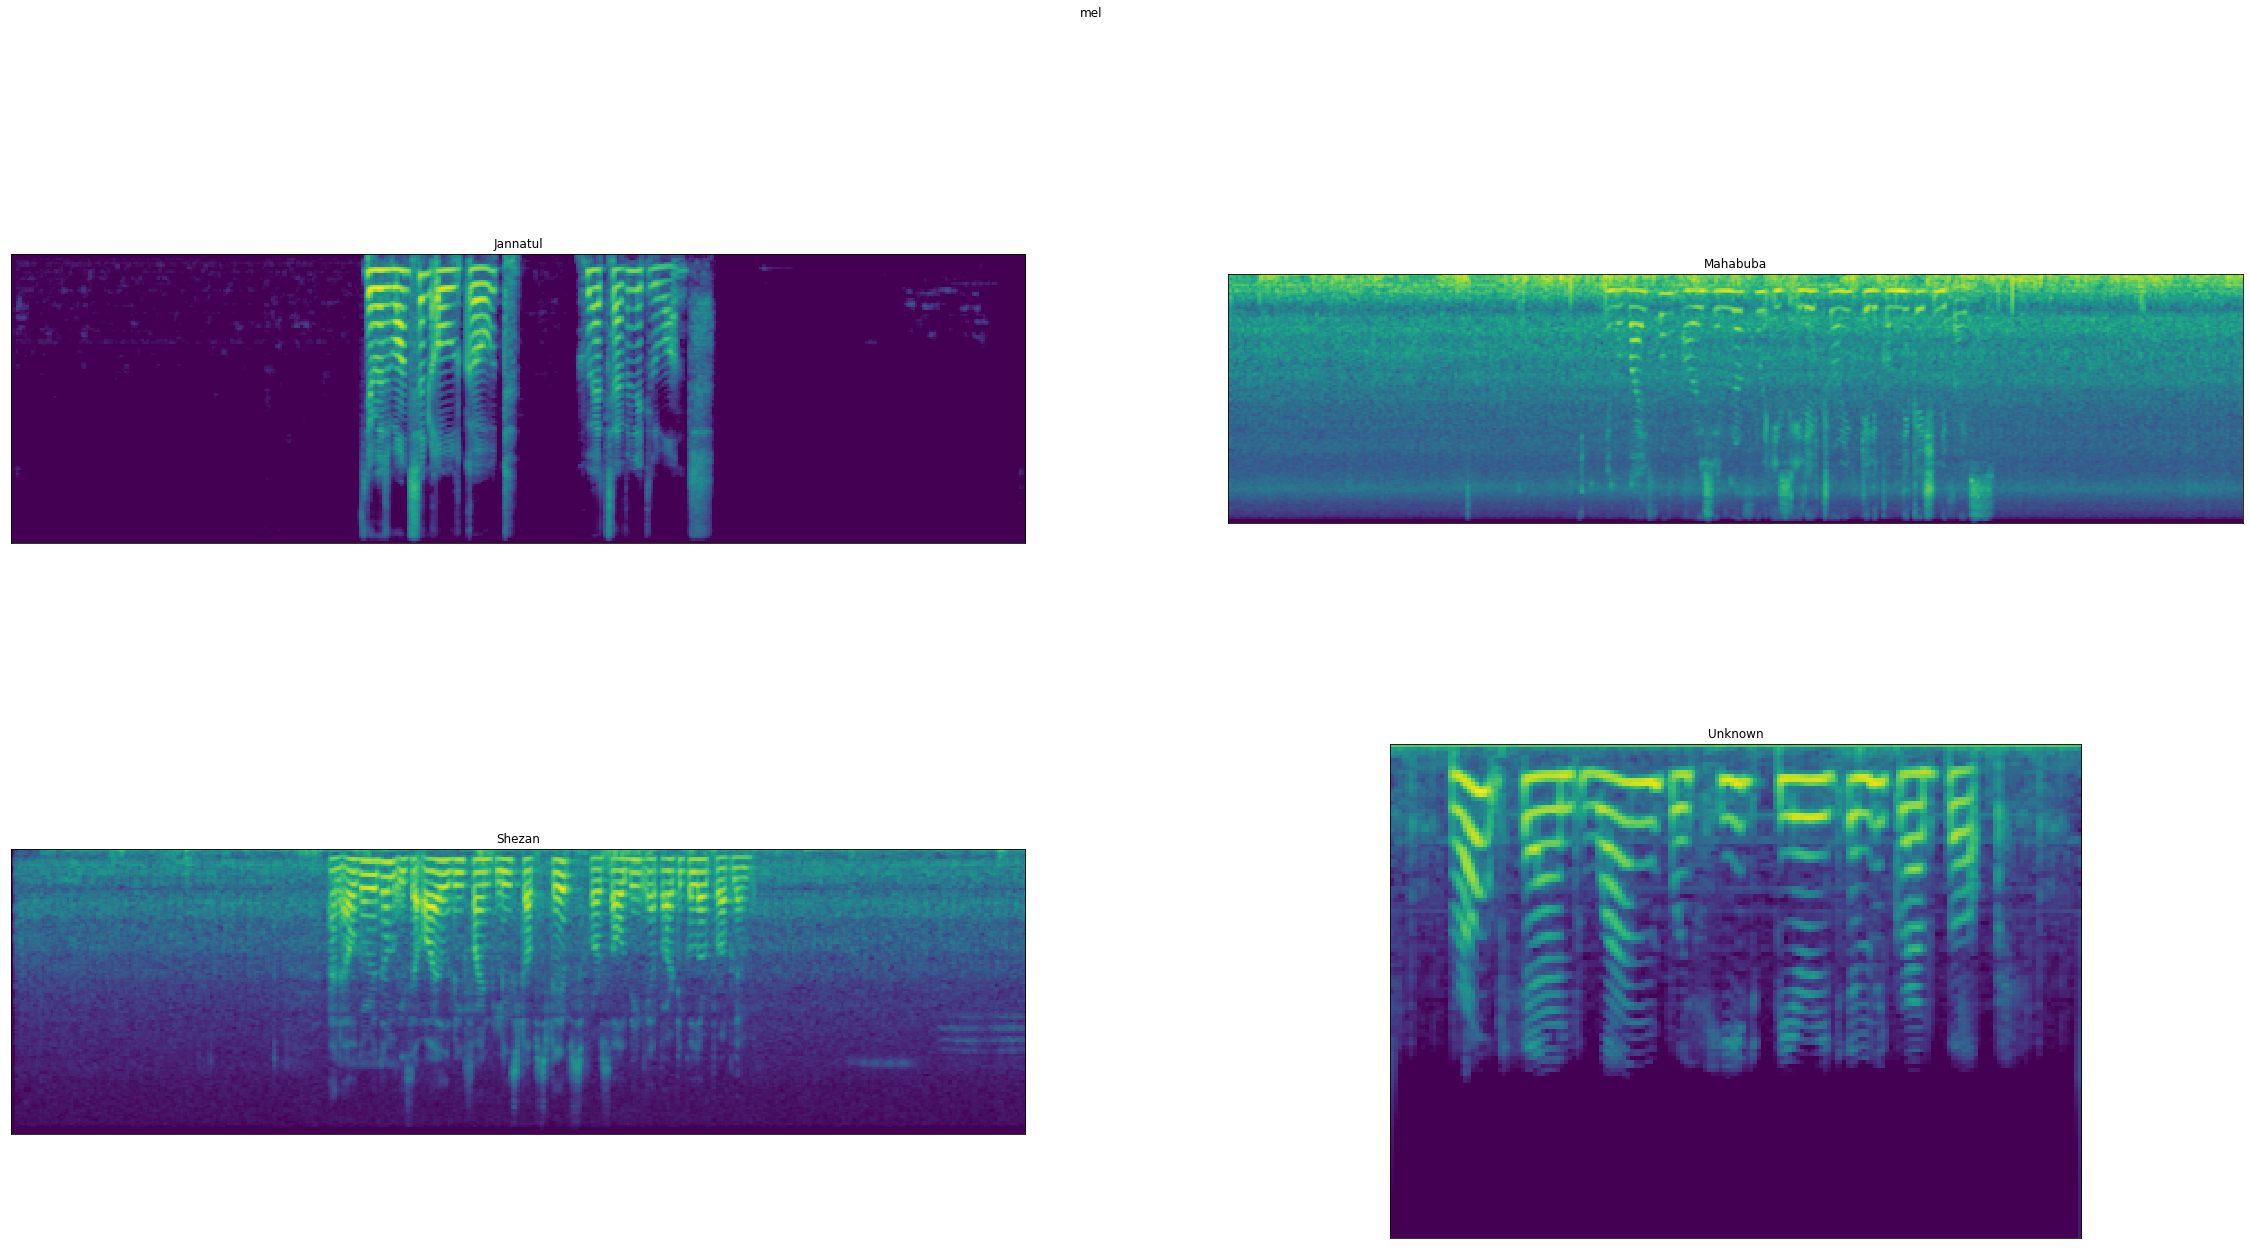

In [ ]:
dis_feature(mel_spectrograms)

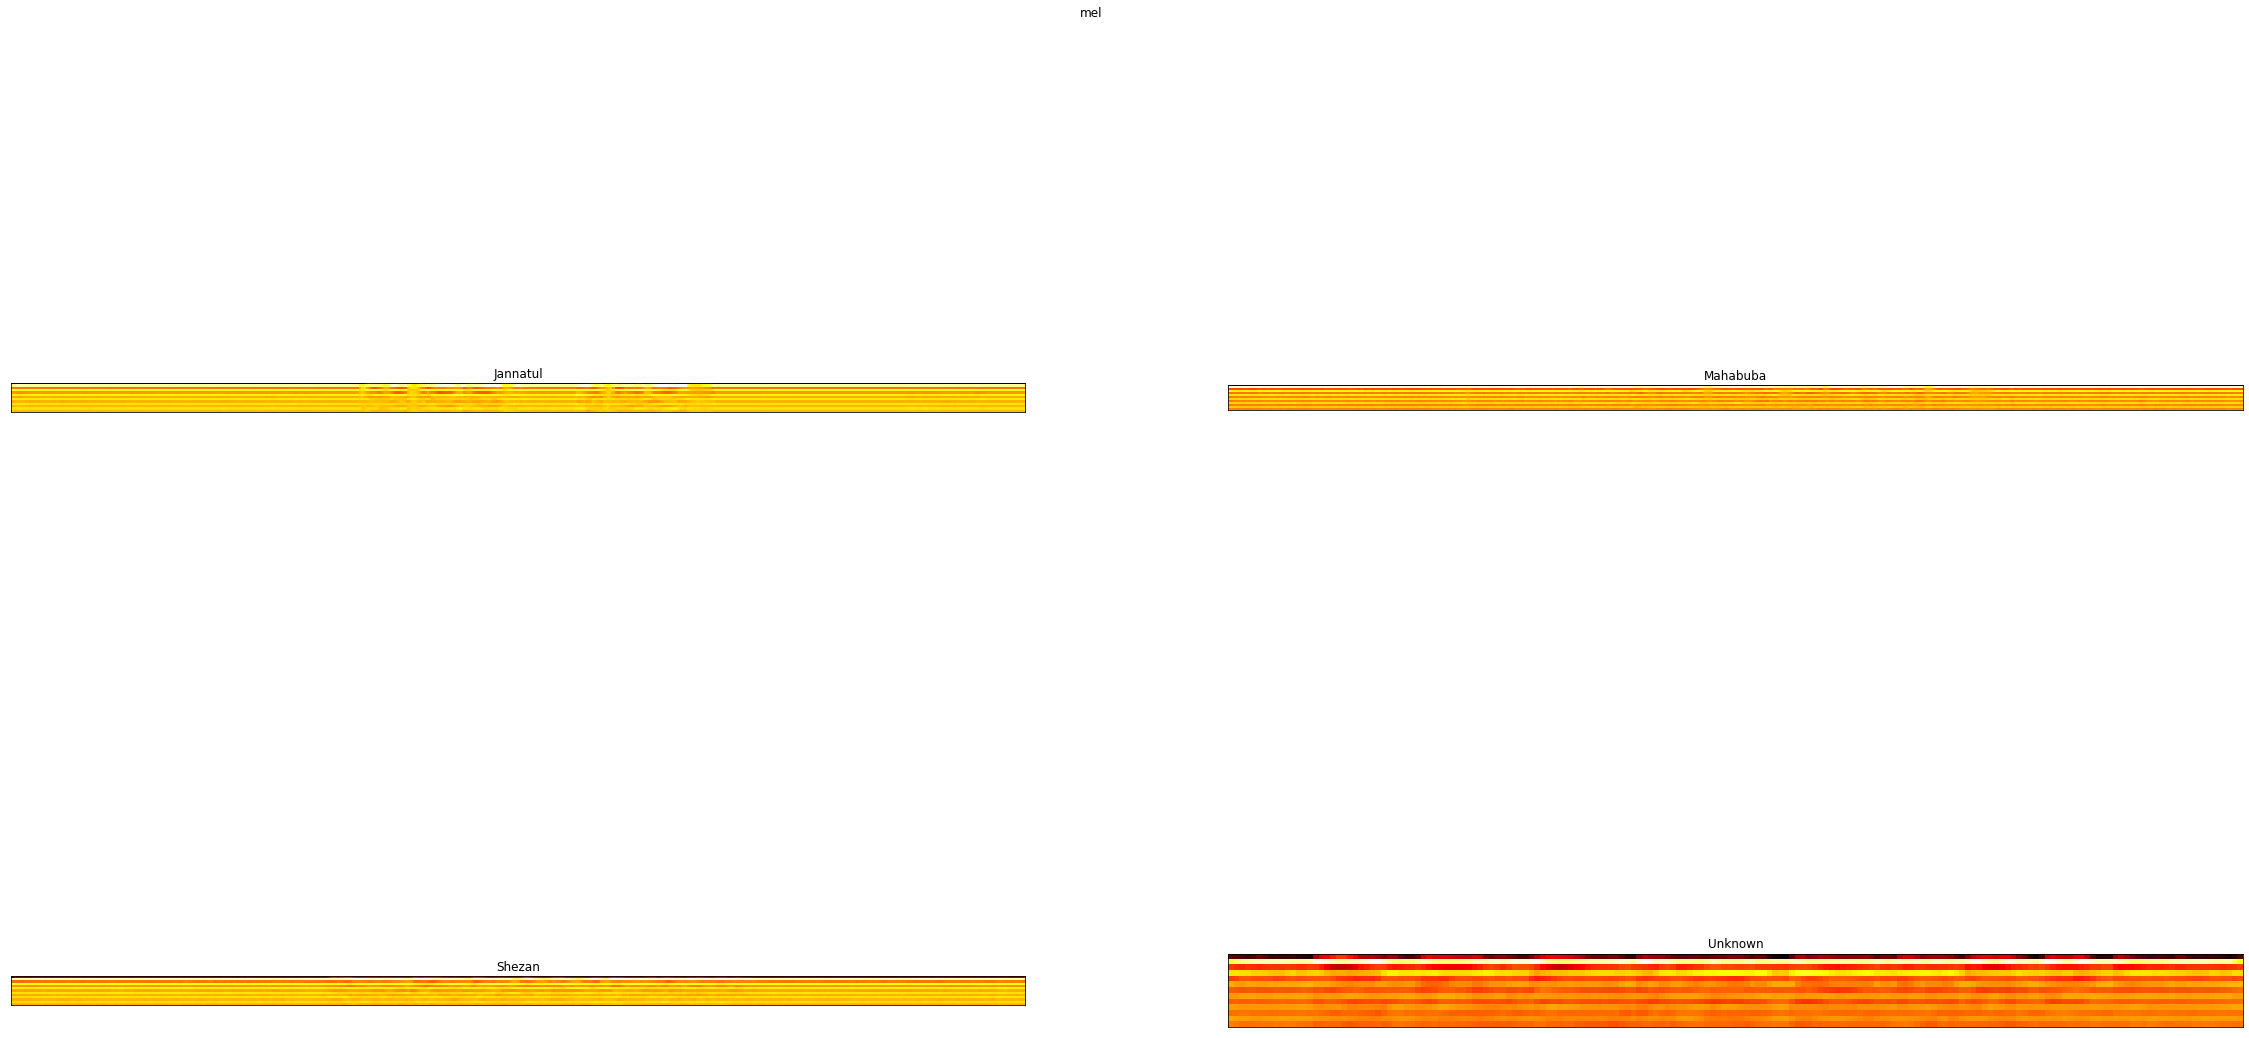

In [ ]:
dis_feature(mfccs, cmap='hot')

> Here we extracted two features mel-spectrogram and mfcc.
> we had tried to use both feature for training and mfcc performed very well.
> So, here we are going to use mfcc for training.

## Step 4. Getting Data ready for training

* Now we are going to take a three random 2 second clip from each audio file. this will increase the data size and also classification speed increases.
* the following code iterate through every file and take three random clip from it.

In [ ]:
X , y = [] , []
for data in tqdm(df.iterrows()):
  sig , sr = librosa.load(data[1][0])
  for i in range(3):
    n = np.random.randint(0, len(sig)-(sr*2))
    sig_ = sig[n : int(n+(sr*2))]
    mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=13)
    reduced_noise = nr.reduce_noise(mfcc_, sr)
    X.append(reduced_noise)
    y.append(data[1][1])

# convert list to numpy array
X = np.array(X) 
y = np.array(y)

#one-hot encoding the target
y = tf.keras.utils.to_categorical(y , num_classes=4)

# our tensorflow model takes input as (no_of_sample , height , width , channel).
# here X has dimension (no_of_sample , height , width).
# So, the below code will reshape it to (no_of_sample , height , width , 1).
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

703it [23:31,  2.01s/it]


In [ ]:
X.shape
y.shape

(2109, 13, 87, 1)

(2109, 4)

In [ ]:
x_train , x_val , y_train , y_val = train_test_split(X , y ,test_size=0.2, random_state=2020)

## Step 5. Model

In [ ]:
INPUTSHAPE = (13,87,1)

In [ ]:
model =  models.Sequential([
                          layers.Conv2D(16 , (3,3),activation = 'relu',padding='valid',input_shape = INPUTSHAPE),
                          layers.Conv2D(16, (3,3), activation='relu',padding='valid'),

                          layers.Conv2D(32, (3,3), activation='relu',padding='valid'),
                          layers.Conv2D(32, (3,3), activation='relu',padding='valid'),

                          layers.Conv2D(64, (3,3), activation='relu',padding='valid'),
                          layers.Conv2D(32, (3,3), activation='relu',padding='valid'),
                          layers.GlobalAveragePooling2D(),


                          layers.Dense(32 , activation = 'relu'),
                          layers.Dense(4 , activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'acc')

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 11, 85, 16)        160       
                                                                 
 conv2d_27 (Conv2D)          (None, 9, 83, 16)         2320      
                                                                 
 conv2d_28 (Conv2D)          (None, 7, 81, 32)         4640      
                                                                 
 conv2d_29 (Conv2D)          (None, 5, 79, 32)         9248      
                                                                 
 conv2d_30 (Conv2D)          (None, 3, 77, 64)         18496     
                                                                 
 conv2d_31 (Conv2D)          (None, 1, 75, 32)         18464     
                                                                 
 global_average_pooling2d_4   (None, 32)              

In [ ]:
%mkdir ".../Speaker-recognition/Model/cpkt"
%mkdir ".../Speaker-recognition/Model/logs"

mkdir: cannot create directory ‘/content/drive/MyDrive/Voice Recognition Project/Model_1/cpkt’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/Voice Recognition Project/Model_1/logs’: File exists


In [ ]:
LOGDIR = ".../Speaker-recognition/Model/logs"
CPKT = ".../Speaker-recognition/Model/cpkt/"

In [ ]:
#this callback is used to prevent overfitting.
callback_1 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

#this checkpoint saves the best weights of model at every epoch
callback_2 = tf.keras.callbacks.ModelCheckpoint(
    CPKT, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None
)

#this is for tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOGDIR)


In [ ]:
history = model.fit(x_train,y_train ,
            validation_split=0.2,
            epochs=100,
            callbacks = [callback_1 , callback_2 , tensorboard_callback])

Epoch 1/100
43/43 [==============================] - 1s 15ms/step - loss: 0.7268 - acc: 0.7242 - val_loss: 0.4269 - val_acc: 0.8609
Epoch 2/100
43/43 [==============================] - 0s 10ms/step - loss: 0.2910 - acc: 0.9073 - val_loss: 0.2576 - val_acc: 0.9201
Epoch 3/100
43/43 [==============================] - 0s 9ms/step - loss: 0.2206 - acc: 0.9177 - val_loss: 0.1816 - val_acc: 0.9349
Epoch 4/100
43/43 [==============================] - 0s 9ms/step - loss: 0.1419 - acc: 0.9563 - val_loss: 0.1228 - val_acc: 0.9645
Epoch 5/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0856 - acc: 0.9726 - val_loss: 0.1485 - val_acc: 0.9556
Epoch 6/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0948 - acc: 0.9674 - val_loss: 0.1955 - val_acc: 0.9349
Epoch 7/100
43/43 [==============================] - 0s 9ms/step - loss: 0.0927 - acc: 0.9689 - val_loss: 0.0772 - val_acc: 0.9793
Epoch 8/100
43/43 [==============================] - 0s 9ms/step - loss: 0.0435 -

In [ ]:
model.save('.../Speaker-recognition/Model')

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open(".../Speaker-recognition/Model/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(".../Speaker-recognition/Model/model.h5")
print("Saved model to disk")

4728

Saved model to disk


In [ ]:
# load json and create model
json_file = open('.../Speaker-recognition/Model/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(".../Speaker-recognition/Model/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
loaded_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'acc')
score = loaded_model.evaluate(x_val, y_val, verbose=1)

14/14 [==============================] - 0s 3ms/step - loss: 0.0760 - acc: 0.9810


# Prediction

* Jannatul : 0

* Mahabuba : 1
* Shezan : 2 
* Unknown : 3



In [ ]:
prediction = loaded_model.predict(x_val)
speaker_ids = prediction.argmax(axis=1)
speaker_ids 

array([0, 3, 3, 1, 1, 3, 0, 3, 1, 2, 1, 2, 0, 1, 3, 0, 3, 0, 2, 1, 0, 1,
       3, 2, 1, 2, 1, 1, 1, 2, 3, 3, 0, 2, 1, 3, 0, 2, 2, 3, 2, 1, 1, 1,
       3, 0, 3, 1, 1, 2, 2, 3, 1, 3, 1, 0, 1, 2, 3, 2, 2, 3, 1, 1, 0, 3,
       3, 1, 0, 0, 1, 2, 0, 0, 1, 0, 0, 3, 2, 3, 2, 3, 0, 1, 1, 1, 2, 2,
       2, 2, 0, 2, 3, 1, 3, 3, 0, 0, 3, 1, 0, 0, 1, 0, 0, 2, 0, 3, 1, 1,
       2, 1, 0, 2, 3, 1, 1, 1, 3, 1, 1, 3, 2, 2, 2, 2, 1, 0, 0, 2, 1, 0,
       2, 3, 3, 3, 3, 3, 1, 2, 3, 0, 2, 2, 2, 2, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 3, 0, 3, 0, 2, 3, 1, 3, 1, 0, 3, 0, 3, 1, 3, 1, 1, 2, 2,
       0, 1, 0, 1, 0, 2, 0, 1, 0, 2, 3, 1, 0, 3, 2, 0, 0, 1, 3, 2, 2, 1,
       0, 2, 0, 2, 2, 2, 2, 3, 0, 3, 1, 0, 2, 1, 1, 2, 1, 2, 1, 2, 0, 0,
       2, 2, 1, 2, 1, 0, 3, 0, 1, 2, 2, 2, 2, 1, 3, 1, 3, 3, 0, 0, 3, 1,
       1, 2, 2, 2, 1, 0, 0, 1, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 3, 0, 1,
       1, 0, 3, 0, 3, 1, 1, 1, 3, 0, 1, 0, 2, 1, 2, 0, 1, 3, 2, 0, 0, 1,
       0, 1, 1, 1, 2, 3, 0, 0, 3, 3, 0, 2, 2, 2, 3,

In [ ]:
y_val.argmax(axis=1)

array([0, 3, 3, 1, 1, 3, 0, 3, 1, 2, 1, 2, 0, 1, 3, 0, 3, 0, 2, 1, 0, 1,
       3, 2, 1, 2, 1, 1, 1, 2, 3, 3, 0, 2, 1, 3, 0, 2, 2, 3, 2, 1, 1, 1,
       3, 0, 3, 1, 1, 2, 2, 3, 1, 3, 1, 0, 1, 2, 3, 2, 2, 3, 1, 1, 0, 3,
       3, 1, 0, 0, 1, 2, 0, 0, 1, 0, 0, 3, 2, 3, 2, 3, 0, 1, 1, 1, 2, 2,
       2, 2, 0, 2, 3, 1, 3, 1, 0, 0, 3, 1, 0, 0, 1, 0, 0, 2, 0, 3, 1, 1,
       2, 1, 0, 2, 3, 1, 1, 1, 3, 1, 1, 3, 2, 2, 2, 2, 1, 0, 0, 2, 1, 0,
       2, 3, 3, 3, 3, 0, 1, 2, 3, 0, 2, 2, 2, 2, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 3, 0, 3, 0, 2, 3, 1, 3, 1, 0, 3, 0, 1, 1, 3, 1, 1, 2, 2,
       0, 1, 0, 1, 0, 2, 0, 1, 0, 2, 3, 1, 0, 3, 2, 0, 0, 1, 3, 2, 2, 1,
       0, 2, 0, 2, 2, 2, 2, 3, 0, 3, 1, 0, 2, 1, 1, 2, 1, 2, 1, 2, 0, 0,
       2, 2, 1, 2, 1, 0, 3, 0, 1, 2, 2, 2, 2, 1, 3, 1, 3, 3, 0, 0, 3, 1,
       1, 2, 2, 2, 1, 0, 0, 1, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 3, 1, 1,
       1, 0, 1, 0, 3, 1, 1, 1, 3, 0, 1, 0, 2, 1, 2, 0, 1, 3, 2, 0, 0, 1,
       0, 1, 1, 1, 2, 3, 0, 0, 3, 3, 0, 2, 2, 2, 3,

In [ ]:
a = speaker_ids  == y_val.argmax(axis=1)

In [ ]:
a

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [ ]:
x = a
unique, counts = np.unique(x, return_counts=True)


In [ ]:
unique

array([False,  True])

In [ ]:
counts

array([  8, 414])

<BarContainer object of 2 artists>

Text(0, 0.5, 'Number of observations')

Text(0.5, 1.0, 'Accuracy')

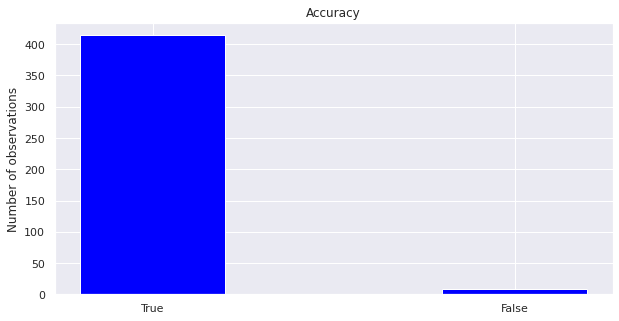

In [ ]:
 # creating the dataset
data = {'True':counts[1], 'False':counts[0]}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='blue',
        width = 0.4)
 
# plt.xlabel("Courses offered")
plt.ylabel("Number of observations")
plt.title("Accuracy")
plt.show()